In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.platform.automl_v4 import AutoML_v4
from pptoolbox.platform.automl_v4.utils import cross_group_predict
from pptoolbox.platform.automl_fusion import select_k_best_trials_fromtrainer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score

import pickle as pkl
from pathlib import Path

# filter data

In [2]:
selections = [
    # 'Chalk',
    'Sulfite'
]

# import data

In [3]:
imported_data = {}

for selection in selections:

    datafolder_path = Path (f"../data/processed/{selection}")
    raw_df = pd.read_csv(datafolder_path / "cleaned_input.csv")
    label_df = pd.read_csv(datafolder_path / "cleaned_label.csv")

    print(raw_df.shape,label_df.shape)

    imported_data = {
        **imported_data,
        f'{selection}_raw' : raw_df,
        f'{selection}_label' : label_df
    }

print(imported_data.keys())


(1072, 192) (1072, 7)
dict_keys(['Sulfite_raw', 'Sulfite_label'])


# train-test split random

In [4]:
imported_types = ['raw', 'label']
data = {}

In [5]:
for selection in selections:
    print(selection)

    for imported_type in imported_types:
        key = f'{selection}_{imported_type}'

        if key in imported_data:
            if imported_type == 'raw':
                raw_df = imported_data[key]
            elif imported_type == 'label':
                label_df = imported_data[key]
                
        print(f'Assigned {key} to {imported_type}_df')

    # random split
    label = label_df.drop_duplicates().set_index('lot_id')

    print("original shapes:",raw_df.shape,label_df.shape)

    sorted_idx = label.index.unique()
    train_label, test_label = train_test_split(label.loc[sorted_idx], test_size=0.1, stratify=label.loc[sorted_idx]['pct'],
                                            shuffle=True, random_state=42)
    
    train_idx = train_label.index
    test_idx = test_label.index

    output_dir = Path(f"../data/processed/{selection}/Profile")
    output_dir.mkdir(exist_ok=True, parents=True)

    X_train = raw_df.set_index('lot_id').loc[train_idx]
    X_test = raw_df.set_index('lot_id').loc[test_idx]
    y_train = label_df.set_index('lot_id').loc[train_idx]
    y_test = label_df.set_index('lot_id').loc[test_idx]

    # data is already preprocessed
    y_train = y_train['pct']
    y_test = y_test['pct']

    print("train-test shapes:",X_train.shape,y_train.shape,X_test.shape,y_test.shape)

    X_train.to_csv(f'{output_dir}/Xtrain.csv')
    X_test.to_csv(f'{output_dir}/Xtest.csv')
    y_train.to_csv(f'{output_dir}/ytrain.csv')
    y_test.to_csv(f'{output_dir}/ytest.csv')

    # X_train = X_train.reset_index()
    # X_test = X_test.reset_index()
    # y_train = y_train.reset_index()
    # y_test = y_test.reset_index()
    
    data = {
        **data,
        f'{selection}_X_train' : X_train,
        f'{selection}_X_test' : X_test,
        f'{selection}_y_train' : y_train,
        f'{selection}_y_test' : y_test,
        }

Sulfite
Assigned Sulfite_raw to raw_df
Assigned Sulfite_label to label_df
original shapes: (1072, 192) (1072, 7)
train-test shapes: (964, 191) (964,) (108, 191) (108,)


In [6]:
data.keys()

dict_keys(['Sulfite_X_train', 'Sulfite_X_test', 'Sulfite_y_train', 'Sulfite_y_test'])

# train-test split by date

In [150]:
# val_df = raw_df[raw_df['date_scanned'] > 1727654400]
# raw_df = raw_df[raw_df['date_scanned'] < 1727654400]
# raw_df.shape, val_df.shape

In [151]:
# label_train = label_df[label_df['lot_id'].isin(raw_df['lot_id'])]
# label_train.to_csv('../data/train_list.csv')

# preprocess

In [7]:
spectra_split = ['X_train', 'X_test', 'y_train', 'y_test']

# data_preprocessed = {}

# data is already preprocessed when imported
data_preprocessed = data.copy()

In [153]:
# for selection in selections:
#     # if selection == 'Sulfite':
#     #     continue
#     for spectrum in spectra_split:

#         key = f'{selection}_{spectrum}'
#         if key in data:
#             if spectrum == 'X_train':
#                 X_train = data[key]
#             elif spectrum == 'X_test':
#                 X_test = data[key]
#             elif spectrum == 'y_train':
#                 y_train = data[key]
#             elif spectrum == 'y_test':
#                 y_test = data[key]
#             print(f'Assigned {key} to {spectrum}_df')

#     y_train = y_train[['lot_id','ABOVE_BELOW_5pct_Dwarf']].drop_duplicates()
#     y_test = y_test[['lot_id','ABOVE_BELOW_5pct_Dwarf']].drop_duplicates()

#     X_train, y_train = preprocess(X_train, y_train,  wavelengths=WAVELENGTHS_3NM_V1)
#     X_test, y_test = preprocess(X_test, y_test,  wavelengths=WAVELENGTHS_3NM_V1)

#     data_preprocessed = {
#     **data_preprocessed,
#     f'{selection}_X_train' : X_train,
#     f'{selection}_X_test' : X_test,
#     f'{selection}_y_train' : y_train,
#     f'{selection}_y_test' : y_test,
#     }

#     print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#     print(data_preprocessed.keys())

# Train Profile

In [169]:
for selection in selections:
    print(selection)
    
    output_dir = Path(f"../models/{selection}/Profile")
    output_dir.mkdir(exist_ok=True, parents=True)

    for spectrum in spectra_split:

        key = f'{selection}_{spectrum}'
        if key in data_preprocessed:
            if spectrum == 'X_train':
                X_train = data_preprocessed[key]
            elif spectrum == 'X_test':
                X_test = data_preprocessed[key]
            elif spectrum == 'y_train':
                y_train = data_preprocessed[key]
            elif spectrum == 'y_test':
                y_test = data_preprocessed[key]
            print(f'Assigned {key} to {spectrum}_df')

    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    trainer = AutoML_v4(
        task_type = "profile", 
        # exploration_runs=100
        )
    trainer.fit(
        X_train, y_train,
        kfold=StratifiedGroupKFold(n_splits=10)
        )
    pkl.dump(trainer, open(output_dir / "trainer.pkl", "wb"))

Sulfite
Assigned Sulfite_X_train to X_train_df
Assigned Sulfite_X_test to X_test_df
Assigned Sulfite_y_train to y_train_df
Assigned Sulfite_y_test to y_test_df
(964, 191) (964,) (108, 191) (108,)
  0%|          | 1/200 [00:01<05:21,  1.61s/trial, best loss: 31.81888700939077]


KeyboardInterrupt: 

# inspect trainer

In [13]:
# inspect trainer

output_dir = Path(f"../models/{selection}/Profile")
output_dir.mkdir(exist_ok=True, parents=True)

for selection in selections:
    print(selection)
    trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))
    display(trainer.get_pipeline())

Sulfite


Pipeline(steps=[('SG1D', SavitzkyGolay(deriv=1, window=17)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PLS', PLSRegression(n_components=31, scale=False))])

## top 5 models

In [14]:
pipelines = select_k_best_trials_fromtrainer(
    trainer, 
    k=5,
    method='strict'
)
pipelines

[('SG1D-Scaler-PLS',
  Pipeline(steps=[('SG1D', SavitzkyGolay(deriv=1, window=17)),
                  ('Scaler', StandardScaler(with_std=False)),
                  ('PLS', PLSRegression(n_components=31, scale=False))])),
 ('Detrend-Scaler-SVR',
  Pipeline(steps=[('Detrend', Detrend()),
                  ('Scaler', StandardScaler(with_std=False)),
                  ('SVR', SVR(C=122.95844941104744, cache_size=2000))])),
 ('SNV-Scaler-OMP',
  Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                  ('OMP', OrthogonalMatchingPursuit())])),
 ('SG1D-Scaler-PCA-Lars',
  Pipeline(steps=[('SG1D', SavitzkyGolay(deriv=1, window=13)),
                  ('Scaler', StandardScaler(with_std=False)),
                  ('PCA', PCA(n_components=23, random_state=42)),
                  ('Lars', Lars(random_state=42))])),
 ('SNV-SG1D-Scaler-PCA-Enet',
  Pipeline(steps=[('SNV', SNV()), ('SG1D', SavitzkyGolay(deriv=1, window=11)),
                  ('Scaler', StandardSca

In [15]:
trainer.get_best_trial()

{'state': 2,
 'tid': 129,
 'spec': None,
 'result': {'loss': 28.168846170418114,
  'cv_results': {'train_r2': 0.33559123314930744,
   'test_r2': 0.10982797813404518,
   'train_neg_root_mean_squared_error': -4.592302517915207,
   'test_neg_root_mean_squared_error': -5.299575489788086,
   'train_neg_mean_squared_error': -21.090426035200984,
   'test_neg_mean_squared_error': -28.168846170418114,
   'train_neg_mean_absolute_error': -3.797708606994038,
   'test_neg_mean_absolute_error': -4.534251449409257,
   'train_max_error': -13.313369329265466,
   'test_max_error': -9.634414612783837},
  'time_taken': 1.613525152206421,
  'pipeline': Pipeline(steps=[('SG1D', SavitzkyGolay(deriv=1, window=17)),
                  ('Scaler', StandardScaler(with_std=False)),
                  ('PLS', PLSRegression(n_components=31, scale=False))]),
  'status': 'ok',
  'exception': None},
 'misc': {'tid': 129,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'C': [],
   'alpha'

# training metrics

Sulfite
Assigned Sulfite_X_train to X_train_df
Assigned Sulfite_X_test to X_test_df
Assigned Sulfite_y_train to y_train_df
Assigned Sulfite_y_test to y_test_df
(964, 191) (964,) (108, 191) (108,)


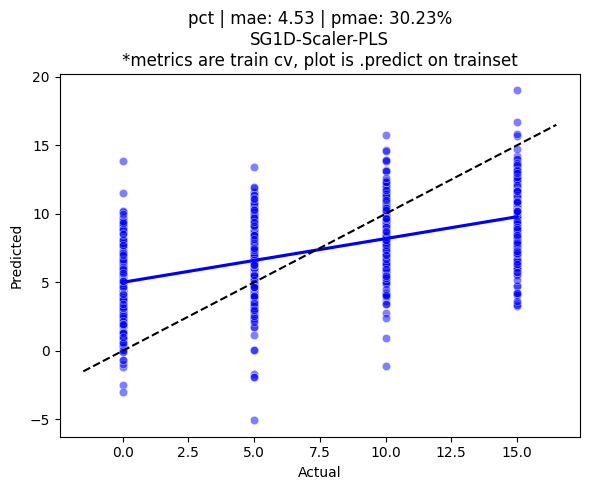

In [16]:
for selection in selections:
    print(selection)
    
    output_dir = Path(f"../models/{selection}/Profile")
    output_dir.mkdir(exist_ok=True, parents=True)

    for spectrum in spectra_split:

        key = f'{selection}_{spectrum}'
        if key in data_preprocessed:
            if spectrum == 'X_train':
                X_train = data_preprocessed[key]
            elif spectrum == 'X_test':
                X_test = data_preprocessed[key]
            elif spectrum == 'y_train':
                y_train = data_preprocessed[key]
            elif spectrum == 'y_test':
                y_test = data_preprocessed[key]
            print(f'Assigned {key} to {spectrum}_df')

    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    X_input = X_train
    y_input = y_train

    label = y_input.name
    y_list = list(y_input)
    
    trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))

    best_trial = trainer.get_best_trial()
    best_cv_results = best_trial["result"]["cv_results"]

    pmae_range = abs(y_input.max() - y_input.min())
    cv_mae = -best_cv_results["test_neg_mean_absolute_error"]
    cv_pmae = (cv_mae * 100) / pmae_range

    metrics = {
        "model": trainer.get_pipeline_name(), 
        "param": label,
        "r2": best_cv_results["test_r2"],
        "mae": -best_cv_results["test_neg_mean_absolute_error"],
        "mse": -best_cv_results["test_neg_mean_squared_error"],
        "rmse": -best_cv_results["test_neg_root_mean_squared_error"],
        "max_error": best_cv_results["test_max_error"],
        "pmae": cv_pmae,
    }

    predictions = pd.DataFrame(trainer.predict(X_input))

    ### round the predictions to the nearest 5
    # predictions = np.round(predictions/5)*5

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_list, y=predictions[0], color='blue', alpha=0.5)
    sns.regplot(x=y_list, y=predictions[0], scatter=False, color='blue', ci=None)
    plt.plot([y_input.min()-y_input.max()*.1, y_input.max()+y_input.max()*.1], 
             [y_input.min()-y_input.max()*.1, y_input.max()+y_input.max()*.1], 
             color='black', linestyle='--')  # Reference line
    plt.title(f'{label} | mae: {float(metrics["mae"]):.2f} | pmae: {float(metrics["pmae"]):.2f}%\n{metrics["model"]}\n*metrics are train cv, plot is .predict on trainset')
    plt.xlabel(f'Actual')
    plt.ylabel(f'Predicted')
    plt.tight_layout()
    plt.savefig(output_dir / f'prederror_{label}_best.png')

    plt.show()
    plt.close()

## top 5 models

Sulfite
Assigned Sulfite_X_train to X_train_df
Assigned Sulfite_X_test to X_test_df
Assigned Sulfite_y_train to y_train_df
Assigned Sulfite_y_test to y_test_df
(964, 191) (964,) (108, 191) (108,)


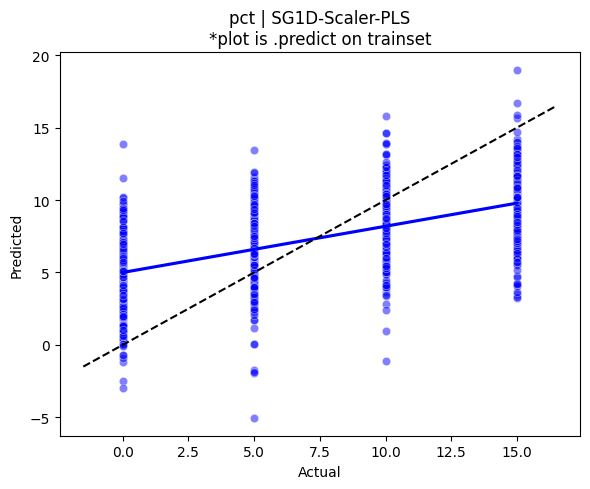

Sulfite
Assigned Sulfite_X_train to X_train_df
Assigned Sulfite_X_test to X_test_df
Assigned Sulfite_y_train to y_train_df
Assigned Sulfite_y_test to y_test_df
(964, 191) (964,) (108, 191) (108,)


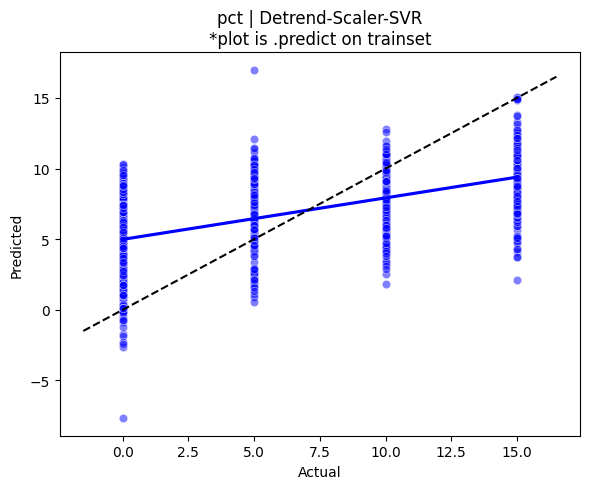

Sulfite
Assigned Sulfite_X_train to X_train_df
Assigned Sulfite_X_test to X_test_df
Assigned Sulfite_y_train to y_train_df
Assigned Sulfite_y_test to y_test_df
(964, 191) (964,) (108, 191) (108,)


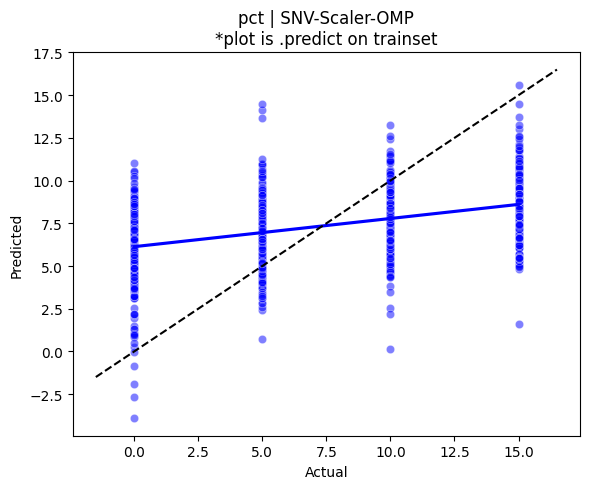

Sulfite
Assigned Sulfite_X_train to X_train_df
Assigned Sulfite_X_test to X_test_df
Assigned Sulfite_y_train to y_train_df
Assigned Sulfite_y_test to y_test_df
(964, 191) (964,) (108, 191) (108,)


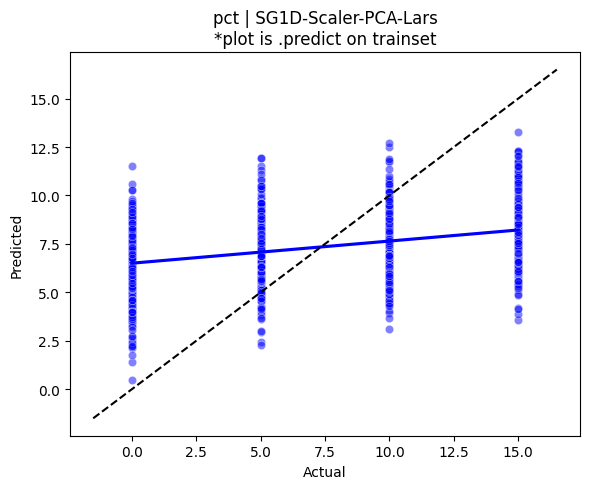

Sulfite
Assigned Sulfite_X_train to X_train_df
Assigned Sulfite_X_test to X_test_df
Assigned Sulfite_y_train to y_train_df
Assigned Sulfite_y_test to y_test_df
(964, 191) (964,) (108, 191) (108,)


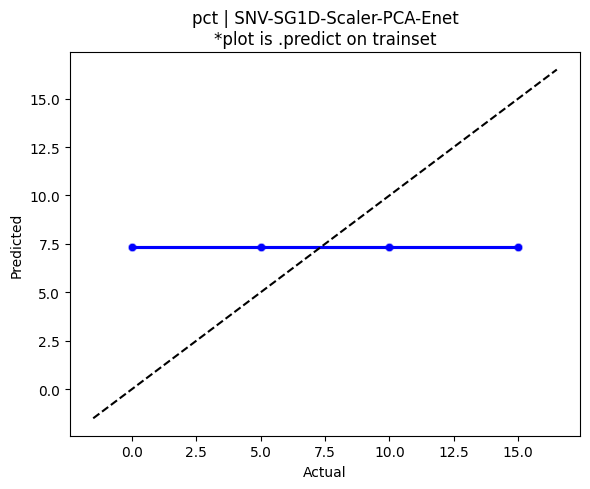

In [17]:
for (name, pipeline) in (pipelines):
    trainer = pipeline
    for selection in selections:
        print(selection)

        for spectrum in spectra_split:

            key = f'{selection}_{spectrum}'
            if key in data_preprocessed:
                if spectrum == 'X_train':
                    X_train = data_preprocessed[key]
                elif spectrum == 'X_test':
                    X_test = data_preprocessed[key]
                elif spectrum == 'y_train':
                    y_train = data_preprocessed[key]
                elif spectrum == 'y_test':
                    y_test = data_preprocessed[key]
                print(f'Assigned {key} to {spectrum}_df')

        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

        X_input = X_train
        y_input = y_train

        label = y_input.name
        y_list = list(y_input)
        
        trainer.fit(X_train, y_train)

        predictions = pd.DataFrame(trainer.predict(X_input))
        
        # round predictions to nearest 5
        # predictions = np.round(predictions/5)*5

        plt.figure(figsize=(6, 5))
        sns.scatterplot(x=y_list, y=predictions[0], color='blue', alpha=0.5)
        sns.regplot(x=y_list, y=predictions[0], scatter=False, color='blue', ci=None)
        plt.plot([y_input.min()-y_input.max()*.1, y_input.max()+y_input.max()*.1], 
                [y_input.min()-y_input.max()*.1, y_input.max()+y_input.max()*.1], 
                color='black', linestyle='--')  # Reference line
        plt.title(f'{label} | {name}\n*plot is .predict on trainset')
        plt.xlabel(f'Actual')
        plt.ylabel(f'Predicted')
        plt.tight_layout()

        plt.show()
        plt.close()

# blinds predict

Sulfite
Assigned Sulfite_X_train to X_train_df
Assigned Sulfite_X_test to X_test_df
Assigned Sulfite_y_train to y_train_df
Assigned Sulfite_y_test to y_test_df
(964, 191) (964,) (108, 191) (108,)
(27, 191) (27,)


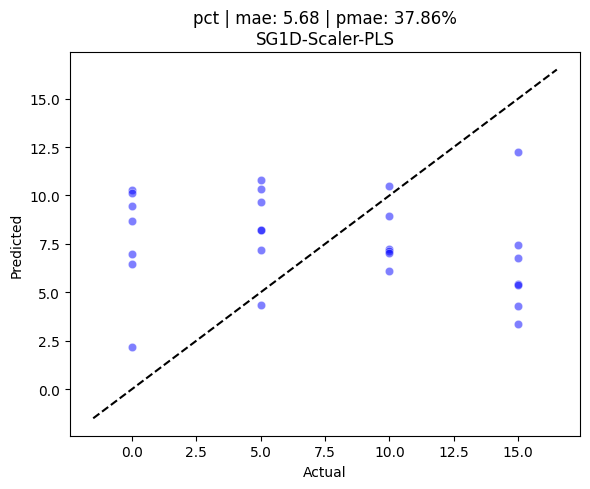

In [20]:
for selection in selections:
    print(selection)
    
    output_dir = Path(f"../models/{selection}/Profile")
    output_dir.mkdir(exist_ok=True, parents=True)

    for spectrum in spectra_split:

        key = f'{selection}_{spectrum}'
        if key in data_preprocessed:
            if spectrum == 'X_train':
                X_train = data_preprocessed[key]
            elif spectrum == 'X_test':
                X_test = data_preprocessed[key]
            elif spectrum == 'y_train':
                y_train = data_preprocessed[key]
            elif spectrum == 'y_test':
                y_test = data_preprocessed[key]
            print(f'Assigned {key} to {spectrum}_df')

    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    X_input = X_test.groupby(X_test.index).mean()
    y_input = y_test.groupby(y_test.index).mean()
    print(X_input.shape, y_input.shape)

    label = y_input.name
    y_list = list(y_input)
    
    trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))

    predictions = pd.DataFrame(trainer.predict(X_input))

    blinds_MAE = np.mean(np.abs(y_input.values - predictions[0].values))
    blinds_pMAE = (blinds_MAE * 100) / abs(y_input.max()-y_input.min()) 

    ### round the predictions to the nearest 5
    # predictions = np.round(predictions/5)*5

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_list, y=predictions[0], color='blue', alpha=0.5)
    plt.plot([y_input.min()-y_input.max()*.1, y_input.max()+y_input.max()*.1], 
             [y_input.min()-y_input.max()*.1, y_input.max()+y_input.max()*.1], 
             color='black', linestyle='--')  # Reference line
    plt.title(f'{label} | mae: {blinds_MAE:.2f} | pmae: {blinds_pMAE:.2f}%\n{metrics["model"]}')
    plt.xlabel(f'Actual')
    plt.ylabel(f'Predicted')
    plt.tight_layout()
    plt.savefig(output_dir / f'prederror_{label}_blind.png')

    plt.show()
    plt.close()

## top 5 models

Sulfite
Assigned Sulfite_X_train to X_train_df
Assigned Sulfite_X_test to X_test_df
Assigned Sulfite_y_train to y_train_df
Assigned Sulfite_y_test to y_test_df
(964, 191) (964,) (108, 191) (108,)
(27, 191) (27,)


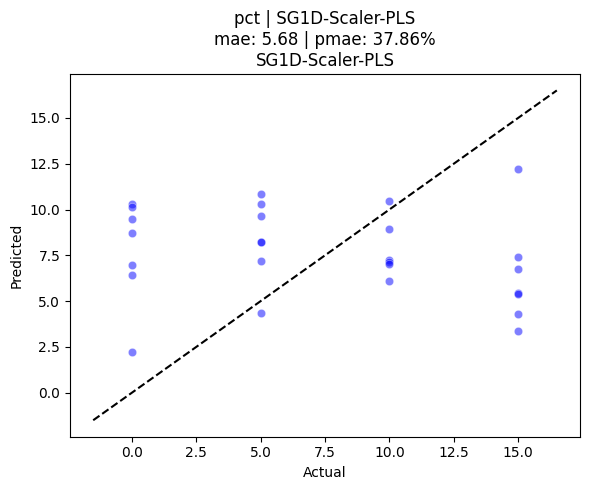

Sulfite
Assigned Sulfite_X_train to X_train_df
Assigned Sulfite_X_test to X_test_df
Assigned Sulfite_y_train to y_train_df
Assigned Sulfite_y_test to y_test_df
(964, 191) (964,) (108, 191) (108,)
(27, 191) (27,)


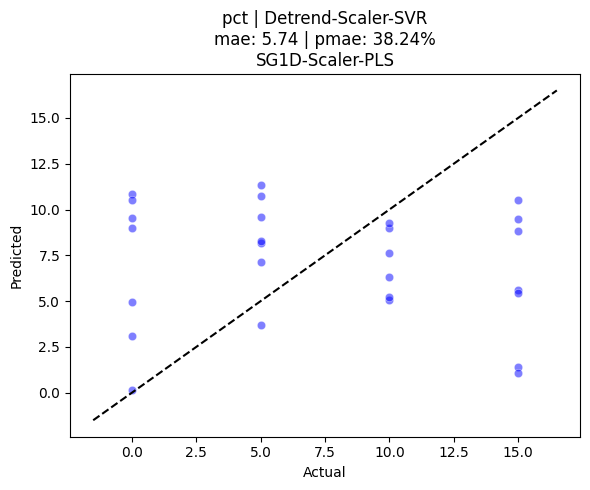

Sulfite
Assigned Sulfite_X_train to X_train_df
Assigned Sulfite_X_test to X_test_df
Assigned Sulfite_y_train to y_train_df
Assigned Sulfite_y_test to y_test_df
(964, 191) (964,) (108, 191) (108,)
(27, 191) (27,)


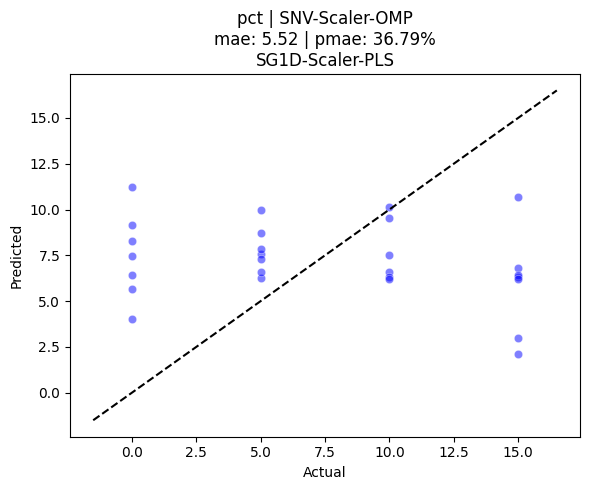

Sulfite
Assigned Sulfite_X_train to X_train_df
Assigned Sulfite_X_test to X_test_df
Assigned Sulfite_y_train to y_train_df
Assigned Sulfite_y_test to y_test_df
(964, 191) (964,) (108, 191) (108,)
(27, 191) (27,)


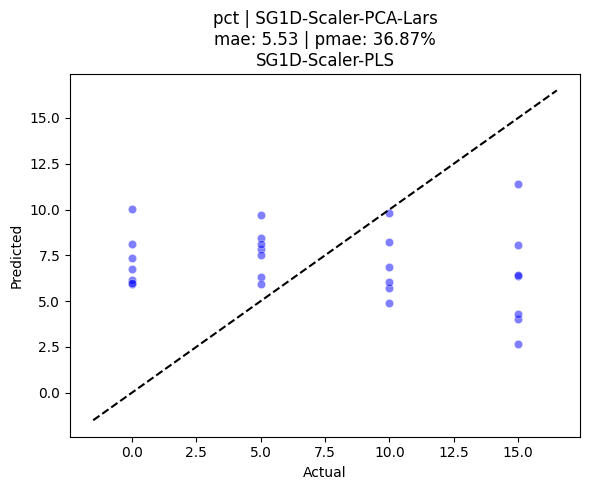

Sulfite
Assigned Sulfite_X_train to X_train_df
Assigned Sulfite_X_test to X_test_df
Assigned Sulfite_y_train to y_train_df
Assigned Sulfite_y_test to y_test_df
(964, 191) (964,) (108, 191) (108,)
(27, 191) (27,)


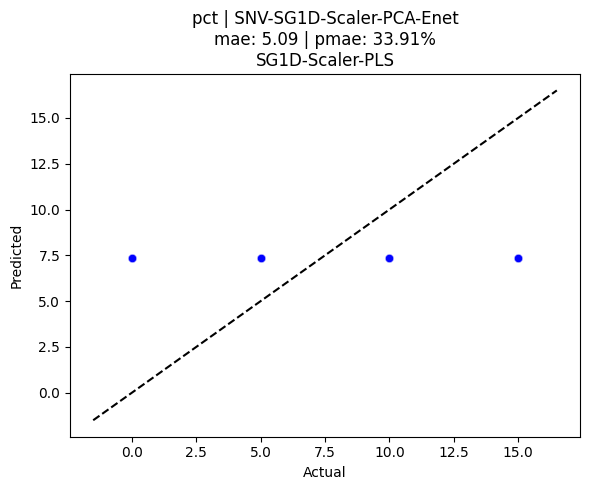

In [21]:
for (name, pipeline) in (pipelines):
    trainer = pipeline
    for selection in selections:
        print(selection)

        for spectrum in spectra_split:

            key = f'{selection}_{spectrum}'
            if key in data_preprocessed:
                if spectrum == 'X_train':
                    X_train = data_preprocessed[key]
                elif spectrum == 'X_test':
                    X_test = data_preprocessed[key]
                elif spectrum == 'y_train':
                    y_train = data_preprocessed[key]
                elif spectrum == 'y_test':
                    y_test = data_preprocessed[key]
                print(f'Assigned {key} to {spectrum}_df')

        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

        X_input = X_test.groupby(X_test.index).mean()
        y_input = y_test.groupby(y_test.index).mean()
        print(X_input.shape, y_input.shape)

        label = y_input.name
        y_list = list(y_input)
        
        trainer.fit(X_train, y_train)

        predictions = pd.DataFrame(trainer.predict(X_input))

        blinds_MAE = np.mean(np.abs(y_input.values - predictions[0].values))
        blinds_pMAE = (blinds_MAE * 100) / abs(y_input.max()-y_input.min()) 
        
        # round predictions to nearest 5
        # predictions = np.round(predictions/5)*5

        plt.figure(figsize=(6, 5))
        sns.scatterplot(x=y_list, y=predictions[0], color='blue', alpha=0.5)
        plt.plot([y_input.min()-y_input.max()*.1, y_input.max()+y_input.max()*.1], 
                [y_input.min()-y_input.max()*.1, y_input.max()+y_input.max()*.1], 
                color='black', linestyle='--')  # Reference line
        plt.title(f'{label} | {name}\nmae: {blinds_MAE:.2f} | pmae: {blinds_pMAE:.2f}%\n{metrics["model"]}')
        plt.xlabel(f'Actual')
        plt.ylabel(f'Predicted')
        plt.tight_layout()

        plt.show()
        plt.close()